In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
import random
import math
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from collections import deque, namedtuple
import time
import gym
import pandas as pd

def weight_init(layers):
    for layer in layers:
        torch.nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')

In [2]:
class QR_DQN(nn.Module):
    def __init__(self, state_size, action_size,layer_size, n_step, seed, N, layer_type="ff"):
        super(QR_DQN, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.input_shape = state_size
        self.action_size = action_size
        self.N = N

        self.head_1 = nn.Linear(self.input_shape[0], layer_size)
        self.ff_1 = nn.Linear(layer_size, layer_size)
        self.ff_2 = nn.Linear(layer_size, action_size*N)
        weight_init([self.head_1, self.ff_1])


    
    def forward(self, input):
        """
        
        """
        x = torch.relu(self.head_1(input))
        x = torch.relu(self.ff_1(x))
        out = self.ff_2(x)
        
        return out.view(input.shape[0], self.N, self.action_size)
    def get_action(self,input):
        x = self.forward(input)
        return x.mean(dim=1)

In [3]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size, device, seed, gamma, n_step=1):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.device = device
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        self.gamma = gamma
        self.n_step = n_step
        self.n_step_buffer = deque(maxlen=self.n_step)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        #print("before:", state,action,reward,next_state, done)
        self.n_step_buffer.append((state, action, reward, next_state, done))
        if len(self.n_step_buffer) == self.n_step:
            state, action, reward, next_state, done = self.calc_multistep_return()
            #print("after:",state,action,reward,next_state, done)
            e = self.experience(state, action, reward, next_state, done)
            self.memory.append(e)
    
    def calc_multistep_return(self):
        Return = 0
        for idx in range(self.n_step):
            Return += self.gamma**idx * self.n_step_buffer[idx][2]
        
        return self.n_step_buffer[0][0], self.n_step_buffer[0][1], Return, self.n_step_buffer[-1][3], self.n_step_buffer[-1][4]
        
    
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.stack([e.state for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(self.device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.stack([e.next_state for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [4]:
class DQN_Agent():
    """Interacts with and learns from the environment."""

    def __init__(self,
                 state_size,
                 action_size,
                 Network,
                 layer_size,
                 n_step,
                 BATCH_SIZE,
                 BUFFER_SIZE,
                 LR,
                 TAU,
                 GAMMA,
                 UPDATE_EVERY,
                 device,
                 seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            Network (str): dqn network type
            layer_size (int): size of the hidden layer
            BATCH_SIZE (int): size of the training batch
            BUFFER_SIZE (int): size of the replay memory
            LR (float): learning rate
            TAU (float): tau for soft updating the network weights
            GAMMA (float): discount factor
            UPDATE_EVERY (int): update frequency
            device (str): device that is used for the compute
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.device = device
        self.TAU = TAU
        self.GAMMA = GAMMA
        self.UPDATE_EVERY = UPDATE_EVERY
        self.BATCH_SIZE = BATCH_SIZE
        self.Q_updates = 0
        self.n_step = n_step
        self.N = 32
        self.quantile_tau = torch.FloatTensor([i/self.N for i in range(1,self.N+1)]).to(device)

        self.action_step = 4
        self.last_action = None

        # Q-Network
        self.qnetwork_local = QR_DQN(state_size, action_size,layer_size, n_step, seed, self.N).to(device)
        self.qnetwork_target = QR_DQN(state_size, action_size,layer_size, n_step, seed, self.N).to(device)

        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)
        print(self.qnetwork_local)
        
        # Replay memory
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, self.device, seed, self.GAMMA, n_step)
        
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done, writer):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % self.UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.BATCH_SIZE:
                experiences = self.memory.sample()
                loss = self.learn(experiences)
                self.Q_updates += 1
                writer.add_scalar("Q_loss", loss, self.Q_updates)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy. Acting only every 4 frames!
        
        Params
        ======
            frame: to adjust epsilon
            state (array_like): current state
            
        """

        if self.action_step == 4:
            state = np.array(state)

            state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
            self.qnetwork_local.eval()
            with torch.no_grad():
                action_values = self.qnetwork_local.get_action(state)
            self.qnetwork_local.train()

            # Epsilon-greedy action selection
            if random.random() > eps: # select greedy action if random number is higher than epsilon or noisy network is used!
                action = np.argmax(action_values.cpu().data.numpy())
                self.last_action = action
                return action
            else:
                action = random.choice(np.arange(self.action_size))
                self.last_action = action 
                return action
            #self.action_step = 0
        else:
            self.action_step += 1
            return self.last_action

    def learn(self, experiences):
        """Update value parameters using given batch of experience tuples.
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        self.optimizer.zero_grad()
        states, actions, rewards, next_states, dones = experiences
        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().cpu() #.max(2)[0].unsqueeze(1) #(batch_size, 1, N)
        action_indx = torch.argmax(Q_targets_next.mean(dim=1), dim=1, keepdim=True)

        Q_targets_next = Q_targets_next.gather(2, action_indx.unsqueeze(-1).expand(self.BATCH_SIZE, self.N, 1)).transpose(1,2)

        assert Q_targets_next.shape == (self.BATCH_SIZE,1, self.N)
        # Compute Q targets for current states 
        Q_targets = rewards.unsqueeze(-1) + (self.GAMMA**self.n_step * Q_targets_next.to(self.device) * (1 - dones.unsqueeze(-1)))
        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(2, actions.unsqueeze(-1).expand(self.BATCH_SIZE, self.N, 1))
        # Compute loss
        td_error = Q_targets - Q_expected
        assert td_error.shape == (self.BATCH_SIZE, self.N, self.N), "wrong td error shape"
        huber_l = calculate_huber_loss(td_error, 1.0)
        quantil_l = abs(self.quantile_tau -(td_error.detach() < 0).float()) * huber_l / 1.0

        loss = quantil_l.sum(dim=1).mean(dim=1) # , keepdim=True if per weights get multipl
        loss = loss.mean()
        # Minimize the loss
        loss.backward()
        #clip_grad_norm_(self.qnetwork_local.parameters(),1)
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target)
        return loss.detach().cpu().numpy()            

    def soft_update(self, local_model, target_model):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.TAU*local_param.data + (1.0-self.TAU)*target_param.data)
            
def calculate_huber_loss(td_errors, k=1.0):
    """
    Calculate huber loss element-wisely depending on kappa k.
    """
    loss = torch.where(td_errors.abs() <= k, 0.5 * td_errors.pow(2), k * (td_errors.abs() - 0.5 * k))
    assert loss.shape == (td_errors.shape[0], 32, 32), "huber loss has wrong shape"
    return loss

def eval_runs(eps, frame):
    """
    Makes an evaluation run with the current epsilon
    """
    env = gym.make("LunarLander-v2")
    reward_batch = []
    for i in range(5):
        state = env.reset()
        rewards = 0
        while True:
            action = agent.act(state, eps)
            state, reward, done, _ = env.step(action)
            rewards += reward
            if done:
                break
        reward_batch.append(rewards)
        
    writer.add_scalar("Reward", np.mean(reward_batch), frame)

  0%|                                                                             | 46/120000 [00:00<04:27, 448.82it/s]

Using  cpu
QR_DQN(
  (head_1): Linear(in_features=8, out_features=256, bias=True)
  (ff_1): Linear(in_features=256, out_features=256, bias=True)
  (ff_2): Linear(in_features=256, out_features=128, bias=True)
)


  0%|                                                                             | 91/120000 [00:00<10:13, 195.60it/s]

Episode 1	Frame 61 	Average Score: -82.06

  0%|                                                                            | 160/120000 [00:00<11:46, 169.73it/s]

Episode 2	Frame 132 	Average Score: -132.18

  0%|▏                                                                           | 224/120000 [00:01<15:15, 130.84it/s]

Episode 3	Frame 202 	Average Score: -122.28

  0%|▏                                                                           | 338/120000 [00:02<17:42, 112.64it/s]

Episode 4	Frame 325 	Average Score: -136.84

  0%|▎                                                                           | 458/120000 [00:03<15:52, 125.55it/s]

Episode 5	Frame 445 	Average Score: -131.06

  0%|▎                                                                           | 581/120000 [00:04<14:56, 133.27it/s]

Episode 6	Frame 562 	Average Score: -152.74

  1%|▍                                                                           | 654/120000 [00:04<14:40, 135.49it/s]

Episode 7	Frame 635 	Average Score: -141.67

  1%|▍                                                                           | 732/120000 [00:05<14:32, 136.66it/s]

Episode 8	Frame 717 	Average Score: -131.23

  1%|▌                                                                           | 845/120000 [00:06<15:38, 126.90it/s]

Episode 9	Frame 825 	Average Score: -137.15

  1%|▌                                                                           | 969/120000 [00:07<15:02, 131.92it/s]

Episode 10	Frame 951 	Average Score: -125.64

  1%|▋                                                                          | 1058/120000 [00:08<16:23, 120.91it/s]

Episode 11	Frame 1044 	Average Score: -121.38

  1%|▋                                                                          | 1197/120000 [00:09<15:09, 130.65it/s]

Episode 12	Frame 1182 	Average Score: -134.44

  1%|▊                                                                          | 1300/120000 [00:10<17:03, 115.96it/s]

Episode 13	Frame 1277 	Average Score: -156.71

  1%|▊                                                                           | 1373/120000 [00:10<22:39, 87.24it/s]

Episode 14	Frame 1362 	Average Score: -151.26

  1%|▉                                                                          | 1473/120000 [00:11<16:47, 117.66it/s]

Episode 15	Frame 1460 	Average Score: -146.64

  1%|█                                                                          | 1646/120000 [00:13<15:47, 124.88it/s]

Episode 16	Frame 1631 	Average Score: -143.64

  1%|█                                                                          | 1764/120000 [00:14<16:31, 119.30it/s]

Episode 17	Frame 1752 	Average Score: -138.78

  2%|█▏                                                                         | 1925/120000 [00:15<16:14, 121.18it/s]

Episode 18	Frame 1913 	Average Score: -129.99

  2%|█▎                                                                         | 2161/120000 [00:17<17:20, 113.24it/s]

Episode 19	Frame 2150 	Average Score: -127.51

  2%|█▍                                                                         | 2352/120000 [00:19<16:43, 117.20it/s]

Episode 20	Frame 2331 	Average Score: -120.74

  2%|█▌                                                                          | 2544/120000 [00:21<19:47, 98.91it/s]

Episode 21	Frame 2524 	Average Score: -120.58

  2%|█▋                                                                         | 2736/120000 [00:22<19:01, 102.77it/s]

Episode 22	Frame 2721 	Average Score: -120.34

  2%|█▊                                                                         | 2815/120000 [00:23<18:26, 105.91it/s]

Episode 23	Frame 2801 	Average Score: -117.69

  2%|█▊                                                                          | 2883/120000 [00:24<22:02, 88.55it/s]

Episode 24	Frame 2875 	Average Score: -113.45

  3%|██▏                                                                         | 3405/120000 [00:34<22:07, 87.80it/s]

Episode 25	Frame 3397 	Average Score: -110.38

  3%|██▏                                                                        | 3509/120000 [00:35<17:29, 110.98it/s]

Episode 26	Frame 3490 	Average Score: -106.29

  3%|██▎                                                                        | 3605/120000 [00:36<18:04, 107.28it/s]

Episode 27	Frame 3588 	Average Score: -104.52

  3%|██▍                                                                        | 3845/120000 [00:38<18:06, 106.92it/s]

Episode 28	Frame 3825 	Average Score: -102.84

  4%|███                                                                         | 4797/120000 [00:52<21:38, 88.69it/s]

Episode 29	Frame 4782 	Average Score: -106.60

  5%|███▌                                                                        | 5617/120000 [01:05<22:18, 85.47it/s]

Episode 30	Frame 5608 	Average Score: -109.48

  6%|████▏                                                                       | 6615/120000 [01:29<19:15, 98.15it/s]

Episode 31	Frame 6608 	Average Score: -107.81

  6%|████▊                                                                       | 7625/120000 [01:48<20:47, 90.07it/s]

Episode 32	Frame 7608 	Average Score: -107.74

  6%|████▊                                                                      | 7763/120000 [01:49<17:18, 108.04it/s]

Episode 33	Frame 7748 	Average Score: -103.92

  7%|████▉                                                                      | 7886/120000 [01:50<14:35, 128.06it/s]

Episode 34	Frame 7869 	Average Score: -102.12

  7%|█████▌                                                                     | 8883/120000 [02:11<18:00, 102.86it/s]

Episode 35	Frame 8869 	Average Score: -98.31

  8%|██████                                                                     | 9748/120000 [02:22<18:17, 100.48it/s]

Episode 36	Frame 9732 	Average Score: -90.77

  9%|██████▋                                                                    | 10749/120000 [02:39<18:29, 98.43it/s]

Episode 37	Frame 10732 	Average Score: -88.62

 10%|███████▎                                                                   | 11753/120000 [03:00<18:10, 99.23it/s]

Episode 38	Frame 11732 	Average Score: -85.86

 11%|███████▊                                                                  | 12667/120000 [03:22<17:49, 100.39it/s]

Episode 39	Frame 12651 	Average Score: -80.54

 11%|████████▎                                                                 | 13420/120000 [03:37<16:10, 109.83it/s]

Episode 40	Frame 13406 	Average Score: -73.92

 12%|████████▋                                                                  | 13888/120000 [03:41<18:17, 96.66it/s]

Episode 41	Frame 13875 	Average Score: -66.87

 12%|█████████                                                                  | 14511/120000 [03:51<18:30, 95.02it/s]

Episode 42	Frame 14500 	Average Score: -58.85

 12%|█████████▏                                                                | 14908/120000 [03:54<15:44, 111.27it/s]

Episode 43	Frame 14900 	Average Score: -51.14

 13%|█████████▊                                                                | 15857/120000 [04:06<17:13, 100.80it/s]

Episode 44	Frame 15837 	Average Score: -47.75

 14%|██████████▌                                                                | 16851/120000 [04:25<20:50, 82.50it/s]

Episode 45	Frame 16837 	Average Score: -44.06

 14%|██████████▋                                                               | 17250/120000 [04:30<17:05, 100.17it/s]

Episode 46	Frame 17239 	Average Score: -38.45

 15%|██████████▊                                                               | 17501/120000 [04:32<15:13, 112.18it/s]

Episode 47	Frame 17481 	Average Score: -36.68

 15%|███████████▎                                                               | 18050/120000 [04:40<40:54, 41.54it/s]

Episode 48	Frame 18031 	Average Score: -30.53

 16%|███████████▉                                                               | 19040/120000 [04:52<58:43, 28.65it/s]

Episode 49	Frame 19031 	Average Score: -28.13

 16%|████████████▏                                                             | 19691/120000 [04:58<15:15, 109.54it/s]

Episode 50	Frame 19679 	Average Score: -22.06

 17%|████████████▎                                                             | 19908/120000 [05:00<13:53, 120.10it/s]

Episode 51	Frame 19894 	Average Score: -16.05

 17%|████████████▍                                                             | 20243/120000 [05:04<14:33, 114.15it/s]

Episode 52	Frame 20233 	Average Score: -12.36

 17%|████████████▌                                                             | 20437/120000 [05:06<15:35, 106.44it/s]

Episode 53	Frame 20421 	Average Score: -13.29

 17%|████████████▊                                                              | 20575/120000 [05:07<19:52, 83.39it/s]

Episode 54	Frame 20570 	Average Score: -15.14

 17%|████████████▊                                                             | 20858/120000 [05:10<16:12, 101.98it/s]

Episode 55	Frame 20848 	Average Score: -11.43

 18%|█████████████▋                                                             | 21851/120000 [05:20<16:25, 99.63it/s]

Episode 56	Frame 21848 	Average Score: -8.37

 18%|█████████████▋                                                             | 21983/120000 [05:22<19:39, 83.07it/s]

Episode 57	Frame 21977 	Average Score: -7.96

 19%|█████████████▋                                                            | 22267/120000 [05:28<15:34, 104.57it/s]

Episode 58	Frame 22246 	Average Score: -4.47

 19%|██████████████▍                                                            | 23104/120000 [05:39<21:37, 74.65it/s]

Episode 59	Frame 23091 	Average Score: -1.28

 20%|██████████████▊                                                           | 23980/120000 [05:47<15:41, 102.00it/s]

Episode 60	Frame 23966 	Average Score: 1.56

 20%|███████████████                                                           | 24370/120000 [05:53<15:49, 100.71it/s]

Episode 61	Frame 24357 	Average Score: 5.44

 21%|███████████████▏                                                          | 24653/120000 [05:55<14:01, 113.34it/s]

Episode 62	Frame 24633 	Average Score: 9.61

 21%|███████████████▎                                                          | 24788/120000 [05:56<13:57, 113.62it/s]

Episode 63	Frame 24775 	Average Score: 9.92

 21%|███████████████▍                                                          | 24937/120000 [05:58<13:21, 118.60it/s]

Episode 64	Frame 24923 	Average Score: 9.94

 21%|███████████████▌                                                          | 25188/120000 [06:01<13:39, 115.64it/s]

Episode 65	Frame 25167 	Average Score: 7.53

 21%|███████████████▌                                                          | 25332/120000 [06:02<14:00, 112.69it/s]

Episode 66	Frame 25311 	Average Score: 7.86

 21%|███████████████▊                                                          | 25587/120000 [06:04<12:57, 121.47it/s]

Episode 67	Frame 25577 	Average Score: 12.23

 21%|███████████████▊                                                          | 25710/120000 [06:05<14:18, 109.88it/s]

Episode 68	Frame 25703 	Average Score: 12.33

 22%|████████████████▍                                                         | 26637/120000 [06:16<13:32, 114.97it/s]

Episode 69	Frame 26615 	Average Score: 15.34

 22%|████████████████▌                                                         | 26863/120000 [06:18<13:04, 118.70it/s]

Episode 70	Frame 26860 	Average Score: 13.44

 23%|████████████████▊                                                         | 27174/120000 [06:22<14:08, 109.45it/s]

Episode 71	Frame 27162 	Average Score: 16.24

 23%|████████████████▉                                                         | 27375/120000 [06:24<13:39, 113.08it/s]

Episode 72	Frame 27367 	Average Score: 19.78

 23%|█████████████████▍                                                        | 28191/120000 [06:34<14:27, 105.85it/s]

Episode 73	Frame 28183 	Average Score: 22.45

 24%|█████████████████▍                                                        | 28346/120000 [06:35<12:12, 125.08it/s]

Episode 74	Frame 28323 	Average Score: 21.79

 24%|█████████████████▋                                                        | 28728/120000 [06:39<15:00, 101.33it/s]

Episode 75	Frame 28719 	Average Score: 24.12

 24%|█████████████████▊                                                        | 28933/120000 [06:40<13:09, 115.36it/s]

Episode 76	Frame 28920 	Average Score: 27.12

 25%|██████████████████▏                                                       | 29594/120000 [06:47<13:26, 112.03it/s]

Episode 77	Frame 29576 	Average Score: 29.98

 25%|██████████████████▊                                                        | 30103/120000 [06:54<17:13, 87.00it/s]

Episode 78	Frame 30084 	Average Score: 32.73

 25%|██████████████████▋                                                       | 30274/120000 [06:55<12:21, 120.93it/s]

Episode 79	Frame 30258 	Average Score: 35.27

 25%|██████████████████▊                                                       | 30509/120000 [06:57<12:47, 116.57it/s]

Episode 80	Frame 30494 	Average Score: 34.26

 26%|██████████████████▉                                                       | 30708/120000 [06:59<13:41, 108.67it/s]

Episode 81	Frame 30690 	Average Score: 33.87

 26%|███████████████████▎                                                      | 31309/120000 [07:07<14:35, 101.30it/s]

Episode 82	Frame 31297 	Average Score: 36.46

 26%|███████████████████▍                                                      | 31543/120000 [07:09<12:29, 118.06it/s]

Episode 83	Frame 31520 	Average Score: 38.89

 27%|████████████████████▎                                                      | 32530/120000 [07:20<14:50, 98.27it/s]

Episode 84	Frame 32520 	Average Score: 40.24

 27%|████████████████████                                                      | 32625/120000 [07:21<13:55, 104.56it/s]

Episode 85	Frame 32609 	Average Score: 39.93

 27%|████████████████████▌                                                      | 32836/120000 [07:23<17:10, 84.55it/s]

Episode 86	Frame 32828 	Average Score: 42.34

 28%|████████████████████▉                                                      | 33426/120000 [07:35<15:16, 94.48it/s]

Episode 87	Frame 33412 	Average Score: 45.26

 28%|█████████████████████▏                                                     | 33941/120000 [07:40<14:45, 97.14it/s]

Episode 88	Frame 33933 	Average Score: 47.96

 29%|█████████████████████▍                                                     | 34351/120000 [07:50<18:49, 75.83it/s]

Episode 89	Frame 34344 	Average Score: 50.55

 29%|█████████████████████▊                                                     | 34981/120000 [07:57<17:14, 82.18it/s]

Episode 90	Frame 34969 	Average Score: 52.95

 30%|██████████████████████▍                                                    | 35973/120000 [08:12<17:21, 80.67it/s]

Episode 91	Frame 35967 	Average Score: 55.62

 30%|██████████████████████▎                                                   | 36188/120000 [08:18<13:40, 102.16it/s]

Episode 92	Frame 36173 	Average Score: 57.75

 30%|██████████████████████▊                                                    | 36429/120000 [08:20<14:35, 95.43it/s]

Episode 93	Frame 36417 	Average Score: 60.06

 31%|██████████████████████▉                                                    | 36745/120000 [08:24<15:55, 87.17it/s]

Episode 94	Frame 36731 	Average Score: 62.57

 31%|███████████████████████▎                                                   | 37248/120000 [08:33<13:49, 99.77it/s]

Episode 95	Frame 37236 	Average Score: 64.47

 31%|███████████████████████▍                                                   | 37521/120000 [08:36<14:19, 95.92it/s]

Episode 96	Frame 37502 	Average Score: 66.64

 31%|███████████████████████▌                                                   | 37629/120000 [08:37<14:08, 97.06it/s]

Episode 97	Frame 37612 	Average Score: 66.40

 32%|███████████████████████▌                                                  | 38254/120000 [08:47<12:27, 109.39it/s]

Episode 98	Frame 38239 	Average Score: 68.23

 32%|███████████████████████▊                                                  | 38537/120000 [08:50<13:09, 103.25it/s]

Episode 99	Frame 38523 	Average Score: 70.56

 32%|███████████████████████▉                                                  | 38720/120000 [08:51<12:12, 110.96it/s]

Episode 100	Frame 38697	Average Score: 72.777


 33%|████████████████████████▌                                                  | 39290/120000 [08:59<14:13, 94.59it/s]

Episode 101	Frame 39280 	Average Score: 76.18

 33%|████████████████████████▋                                                  | 39424/120000 [09:00<16:02, 83.74it/s]

Episode 102	Frame 39413 	Average Score: 78.05

 33%|████████████████████████▊                                                  | 39776/120000 [09:04<15:10, 88.11it/s]

Episode 103	Frame 39763 	Average Score: 81.85

 33%|█████████████████████████                                                  | 40101/120000 [09:13<23:41, 56.22it/s]

Episode 104	Frame 40089 	Average Score: 86.24

 34%|█████████████████████████▋                                                 | 41098/120000 [09:28<21:04, 62.41it/s]

Episode 105	Frame 41089 	Average Score: 88.90

 34%|█████████████████████████▊                                                 | 41347/120000 [09:31<14:09, 92.58it/s]

Episode 106	Frame 41332 	Average Score: 94.41

 35%|█████████████████████████▌                                                | 41476/120000 [09:32<12:59, 100.76it/s]

Episode 107	Frame 41466 	Average Score: 95.61

 35%|██████████████████████████▍                                                | 42286/120000 [09:43<17:37, 73.49it/s]

Episode 108	Frame 42278 	Average Score: 98.57

 36%|██████████████████████████▊                                                | 42874/120000 [09:50<13:40, 94.00it/s]

Episode 109	Frame 42867 	Average Score: 103.47

 36%|██████████████████████████▉                                                | 43123/120000 [09:54<14:23, 89.00it/s]

Episode 110	Frame 43108 	Average Score: 106.33

 36%|███████████████████████████                                                | 43314/120000 [09:56<13:07, 97.33it/s]

Episode 111	Frame 43302 	Average Score: 109.35

 36%|███████████████████████████▎                                               | 43701/120000 [10:00<15:33, 81.76it/s]

Episode 112	Frame 43698 	Average Score: 115.06

 37%|███████████████████████████▌                                               | 44046/120000 [10:05<22:42, 55.76it/s]

Episode 113	Frame 44038 	Average Score: 121.89

 38%|███████████████████████████▍                                             | 45050/120000 [10:22<1:07:52, 18.41it/s]

Episode 114	Frame 45038 	Average Score: 124.31

 38%|████████████████████████████▎                                              | 45244/120000 [10:24<13:01, 95.61it/s]

Episode 115	Frame 45228 	Average Score: 125.12

 38%|████████████████████████████▌                                              | 45681/120000 [10:28<13:19, 92.96it/s]

Episode 116	Frame 45669 	Average Score: 129.20

 38%|████████████████████████████▊                                              | 46076/120000 [10:40<30:58, 39.78it/s]

Episode 117	Frame 46064 	Average Score: 132.08

 39%|█████████████████████████████▍                                             | 47078/120000 [11:03<43:12, 28.13it/s]

Episode 118	Frame 47064 	Average Score: 133.46

 39%|█████████████████████████████▌                                             | 47208/120000 [11:04<12:17, 98.70it/s]

Episode 119	Frame 47198 	Average Score: 134.58

 40%|█████████████████████████████▋                                             | 47444/120000 [11:07<12:09, 99.49it/s]

Episode 120	Frame 47430 	Average Score: 136.98

 40%|██████████████████████████████                                             | 48019/120000 [11:14<29:47, 40.26it/s]

Episode 121	Frame 48005 	Average Score: 140.76

 40%|██████████████████████████████▏                                            | 48348/120000 [11:17<12:03, 98.98it/s]

Episode 122	Frame 48330 	Average Score: 144.31

 41%|██████████████████████████████▊                                            | 49288/120000 [11:33<12:59, 90.66it/s]

Episode 123	Frame 49273 	Average Score: 147.22

 41%|██████████████████████████████▉                                            | 49442/120000 [11:35<12:37, 93.15it/s]

Episode 124	Frame 49431 	Average Score: 147.63

 42%|███████████████████████████████▍                                           | 50276/120000 [11:52<16:04, 72.30it/s]

Episode 125	Frame 50260 	Average Score: 149.66

 42%|███████████████████████████████▋                                           | 50642/120000 [11:56<13:38, 84.76it/s]

Episode 126	Frame 50636 	Average Score: 152.17

 43%|████████████████████████████████▎                                          | 51627/120000 [12:11<16:25, 69.36it/s]

Episode 127	Frame 51617 	Average Score: 153.60

 44%|████████████████████████████████▉                                          | 52632/120000 [12:23<13:00, 86.32it/s]

Episode 128	Frame 52617 	Average Score: 155.06

 44%|████████████████████████████████▋                                         | 52951/120000 [12:26<10:49, 103.20it/s]

Episode 129	Frame 52930 	Average Score: 159.82

 44%|█████████████████████████████████▏                                         | 53140/120000 [12:30<12:10, 91.48it/s]

Episode 130	Frame 53129 	Average Score: 164.59

 45%|█████████████████████████████████▍                                         | 53423/120000 [12:34<15:32, 71.38it/s]

Episode 131	Frame 53414 	Average Score: 168.16

 45%|█████████████████████████████████▋                                         | 53853/120000 [12:39<16:58, 64.93it/s]

Episode 132	Frame 53841 	Average Score: 171.23

 45%|██████████████████████████████████                                         | 54458/120000 [12:46<10:56, 99.89it/s]

Episode 133	Frame 54440 	Average Score: 173.64

 46%|██████████████████████████████████▏                                        | 54689/120000 [12:48<11:38, 93.57it/s]

Episode 134	Frame 54678 	Average Score: 177.07

 46%|██████████████████████████████████▍                                        | 55148/120000 [13:09<23:44, 45.52it/s]

Episode 135	Frame 55137 	Average Score: 174.07

 46%|██████████████████████████████████▌                                        | 55307/120000 [13:11<13:40, 78.89it/s]

Episode 136	Frame 55300 	Average Score: 172.80

 47%|███████████████████████████████████                                        | 56065/120000 [13:27<29:36, 35.99it/s]

Episode 137	Frame 56047 	Average Score: 175.20

 47%|███████████████████████████████████▎                                       | 56475/120000 [13:32<12:48, 82.71it/s]

Episode 138	Frame 56469 	Average Score: 177.38

 47%|███████████████████████████████████▍                                       | 56721/120000 [13:35<11:23, 92.59it/s]

Episode 139	Frame 56710 	Average Score: 178.36

 47%|███████████████████████████████████▌                                       | 56843/120000 [13:36<10:50, 97.08it/s]

Episode 140	Frame 56830 	Average Score: 176.72

 48%|███████████████████████████████████▊                                       | 57204/120000 [13:44<12:32, 83.49it/s]

Episode 141	Frame 57193 	Average Score: 177.31

 48%|████████████████████████████████████                                       | 57739/120000 [13:50<11:36, 89.36it/s]

Episode 142	Frame 57725 	Average Score: 177.33

 48%|████████████████████████████████████▎                                      | 58136/120000 [13:57<12:39, 81.41it/s]

Episode 143	Frame 58127 	Average Score: 177.18

 49%|████████████████████████████████████▍                                      | 58281/120000 [13:58<10:33, 97.41it/s]

Episode 144	Frame 58276 	Average Score: 176.55

 49%|████████████████████████████████████▋                                      | 58651/120000 [14:03<12:17, 83.23it/s]

Episode 145	Frame 58639 	Average Score: 177.43

 49%|████████████████████████████████████▊                                      | 58957/120000 [14:06<11:37, 87.55it/s]

Episode 146	Frame 58948 	Average Score: 177.69

 49%|████████████████████████████████████▉                                      | 59184/120000 [14:14<11:46, 86.05it/s]

Episode 147	Frame 59172 	Average Score: 180.04

 49%|█████████████████████████████████████                                      | 59387/120000 [14:16<12:51, 78.55it/s]

Episode 148	Frame 59376 	Average Score: 179.76

 50%|█████████████████████████████████████▏                                     | 59577/120000 [14:19<14:13, 70.78it/s]

Episode 149	Frame 59570 	Average Score: 181.67

 50%|█████████████████████████████████████▍                                     | 59956/120000 [14:24<12:28, 80.17it/s]

Episode 150	Frame 59944 	Average Score: 181.71

 50%|█████████████████████████████████████▌                                     | 60181/120000 [14:29<10:45, 92.71it/s]

Episode 151	Frame 60165 	Average Score: 181.93

 50%|█████████████████████████████████████▊                                     | 60491/120000 [14:33<10:39, 93.04it/s]

Episode 152	Frame 60483 	Average Score: 182.48

 51%|█████████████████████████████████████▉                                     | 60628/120000 [14:34<10:16, 96.35it/s]

Episode 153	Frame 60620 	Average Score: 183.57

 51%|██████████████████████████████████████                                     | 60857/120000 [14:37<10:17, 95.84it/s]

Episode 154	Frame 60848 	Average Score: 187.10

 51%|██████████████████████████████████████▎                                    | 61340/120000 [14:43<10:33, 92.57it/s]

Episode 155	Frame 61327 	Average Score: 187.72

 51%|██████████████████████████████████████▌                                    | 61711/120000 [14:47<10:50, 89.64it/s]

Episode 156	Frame 61694 	Average Score: 188.62

 52%|██████████████████████████████████████▉                                    | 62347/120000 [14:54<10:06, 95.01it/s]

Episode 157	Frame 62330 	Average Score: 191.16

 52%|██████████████████████████████████████▌                                   | 62502/120000 [14:56<09:28, 101.23it/s]

Episode 158	Frame 62491 	Average Score: 191.78

 52%|███████████████████████████████████████▎                                   | 62994/120000 [15:02<11:21, 83.59it/s]

Episode 159	Frame 62980 	Average Score: 192.55

 53%|███████████████████████████████████████▉                                   | 63992/120000 [15:14<12:08, 76.89it/s]

Episode 160	Frame 63980 	Average Score: 192.13

 54%|███████████████████████████████████████▋                                  | 64261/120000 [15:22<08:25, 110.35it/s]

Episode 161	Frame 64240 	Average Score: 192.39

 54%|████████████████████████████████████████▊                                  | 65249/120000 [15:37<10:38, 85.80it/s]

Episode 162	Frame 65240 	Average Score: 191.22

 55%|████████████████████████████████████████▉                                  | 65444/120000 [15:39<09:25, 96.52it/s]

Episode 163	Frame 65430 	Average Score: 193.51

 55%|█████████████████████████████████████████▎                                 | 66134/120000 [15:49<12:13, 73.40it/s]

Episode 164	Frame 66130 	Average Score: 195.97

 56%|█████████████████████████████████████████▊                                 | 66844/120000 [15:58<12:09, 72.90it/s]

Episode 165	Frame 66833 	Average Score: 199.87

 56%|█████████████████████████████████████████▉                                 | 67080/120000 [16:03<15:14, 57.85it/s]

Episode 166	Frame 67071 	Average Score: 202.02

 56%|██████████████████████████████████████████                                 | 67300/120000 [16:06<11:33, 76.04it/s]

Episode 167	Frame 67295 	Average Score: 201.98

 56%|██████████████████████████████████████████▎                                | 67753/120000 [16:11<09:50, 88.48it/s]

Episode 168	Frame 67742 	Average Score: 204.64

 57%|██████████████████████████████████████████▌                                | 68179/120000 [16:18<09:51, 87.68it/s]

Episode 169	Frame 68168 	Average Score: 204.93

 57%|██████████████████████████████████████████▊                                | 68485/120000 [16:21<09:57, 86.20it/s]

Episode 170	Frame 68474 	Average Score: 208.57

 57%|███████████████████████████████████████████                                | 68870/120000 [16:25<08:53, 95.77it/s]

Episode 171	Frame 68862 	Average Score: 209.07

 58%|███████████████████████████████████████████▏                               | 69072/120000 [16:29<13:49, 61.42it/s]

Episode 172	Frame 69059 	Average Score: 208.98

 58%|███████████████████████████████████████████▎                               | 69350/120000 [16:33<10:17, 81.98it/s]

Episode 173	Frame 69340 	Average Score: 209.45

 58%|███████████████████████████████████████████▌                               | 69638/120000 [16:36<10:08, 82.80it/s]

Episode 174	Frame 69627 	Average Score: 212.41

 58%|███████████████████████████████████████████▊                               | 70041/120000 [16:43<24:13, 34.37it/s]

Episode 175	Frame 70031 	Average Score: 212.24

 59%|███████████████████████████████████████████▉                               | 70247/120000 [16:45<09:11, 90.30it/s]

Episode 176	Frame 70238 	Average Score: 212.22

 59%|███████████████████████████████████████████▉                               | 70379/120000 [16:47<11:17, 73.26it/s]

Episode 177	Frame 70371 	Average Score: 210.36

 59%|████████████████████████████████████████████▏                              | 70709/120000 [16:51<11:15, 73.02it/s]

Episode 178	Frame 70698 	Average Score: 211.05

 59%|████████████████████████████████████████████▍                              | 71196/120000 [17:00<08:51, 91.89it/s]

Episode 179	Frame 71181 	Average Score: 211.48

 60%|████████████████████████████████████████████                              | 71490/120000 [17:04<07:57, 101.64it/s]

Episode 180	Frame 71479 	Average Score: 214.64

 60%|████████████████████████████████████████████▏                             | 71700/120000 [17:06<07:59, 100.63it/s]

Episode 181	Frame 71688 	Average Score: 217.25

 60%|████████████████████████████████████████████▉                              | 71807/120000 [17:07<08:29, 94.54it/s]

Episode 182	Frame 71795 	Average Score: 215.12

 60%|████████████████████████████████████████████▉                              | 71957/120000 [17:08<08:29, 94.32it/s]

Episode 183	Frame 71940 	Average Score: 215.51

 61%|█████████████████████████████████████████████▍                             | 72635/120000 [17:18<09:09, 86.25it/s]

Episode 184	Frame 72622 	Average Score: 217.03

 61%|█████████████████████████████████████████████▌                             | 72935/120000 [17:21<08:35, 91.24it/s]

Episode 185	Frame 72925 	Average Score: 219.85

 61%|█████████████████████████████████████████████▉                             | 73427/120000 [17:34<09:07, 85.08it/s]

Episode 186	Frame 73417 	Average Score: 220.13

 61%|██████████████████████████████████████████████                             | 73672/120000 [17:37<08:04, 95.67it/s]

Episode 187	Frame 73657 	Average Score: 219.49

 62%|██████████████████████████████████████████████▋                            | 74663/120000 [17:53<10:35, 71.34it/s]

Episode 188	Frame 74657 	Average Score: 218.16

 62%|██████████████████████████████████████████████▊                            | 74894/120000 [17:56<08:23, 89.55it/s]

Episode 189	Frame 74878 	Average Score: 217.69

 63%|██████████████████████████████████████████████▉                            | 75029/120000 [17:59<25:26, 29.46it/s]

Episode 190	Frame 75012 	Average Score: 215.46

 63%|███████████████████████████████████████████████▏                           | 75481/120000 [18:04<09:24, 78.85it/s]

Episode 191	Frame 75474 	Average Score: 214.97

 63%|███████████████████████████████████████████████▏                           | 75573/120000 [18:05<08:42, 85.04it/s]

Episode 192	Frame 75559 	Average Score: 212.92

 63%|███████████████████████████████████████████████▍                           | 75998/120000 [18:10<08:00, 91.67it/s]

Episode 193	Frame 75997 	Average Score: 213.16

 64%|███████████████████████████████████████████████▉                           | 76658/120000 [18:21<07:41, 93.99it/s]

Episode 194	Frame 76647 	Average Score: 213.14

 64%|████████████████████████████████████████████████                           | 76904/120000 [18:23<07:57, 90.26it/s]

Episode 195	Frame 76894 	Average Score: 213.53

 64%|████████████████████████████████████████████████▎                          | 77269/120000 [18:29<09:38, 73.84it/s]

Episode 196	Frame 77257 	Average Score: 213.59

 65%|████████████████████████████████████████████████▍                          | 77509/120000 [18:32<09:12, 76.86it/s]

Episode 197	Frame 77496 	Average Score: 215.58

 65%|████████████████████████████████████████████████▋                          | 77825/120000 [18:36<08:18, 84.56it/s]

Episode 198	Frame 77815 	Average Score: 215.99

 65%|████████████████████████████████████████████████▋                          | 77948/120000 [18:37<08:07, 86.18it/s]

Episode 199	Frame 77940 	Average Score: 213.61

 65%|████████████████████████████████████████████████▊                          | 78123/120000 [18:42<08:22, 83.29it/s]

Episode 200	Frame 78116	Average Score: 213.477


 65%|█████████████████████████████████████████████████                          | 78557/120000 [18:47<07:23, 93.52it/s]

Episode 201	Frame 78547 	Average Score: 213.59

 66%|█████████████████████████████████████████████████▎                         | 78962/120000 [18:52<08:27, 80.91it/s]

Episode 202	Frame 78952 	Average Score: 215.82

 66%|█████████████████████████████████████████████████▍                         | 79056/120000 [18:54<09:51, 69.26it/s]

Episode 203	Frame 79044 	Average Score: 213.23

 67%|██████████████████████████████████████████████████                         | 80059/120000 [19:07<08:50, 75.23it/s]

Episode 204	Frame 80044 	Average Score: 212.30

 67%|██████████████████████████████████████████████████                         | 80157/120000 [19:08<07:21, 90.24it/s]

Episode 205	Frame 80149 	Average Score: 211.36

 67%|██████████████████████████████████████████████████▏                        | 80391/120000 [19:11<07:49, 84.35it/s]

Episode 206	Frame 80379 	Average Score: 211.03

 67%|██████████████████████████████████████████████████▍                        | 80746/120000 [19:15<07:08, 91.54it/s]

Episode 207	Frame 80728 	Average Score: 213.06

 68%|██████████████████████████████████████████████████▊                        | 81259/120000 [19:23<08:11, 78.81it/s]

Episode 208	Frame 81252 	Average Score: 213.49

 68%|██████████████████████████████████████████████████▉                        | 81546/120000 [19:26<06:53, 93.10it/s]

Episode 209	Frame 81529 	Average Score: 213.25

 68%|███████████████████████████████████████████████████▏                       | 81859/120000 [19:29<06:52, 92.46it/s]

Episode 210	Frame 81843 	Average Score: 212.86

 68%|███████████████████████████████████████████████████▎                       | 82195/120000 [19:35<07:35, 83.01it/s]

Episode 211	Frame 82187 	Average Score: 213.31

 69%|███████████████████████████████████████████████████▌                       | 82470/120000 [19:38<07:23, 84.57it/s]

Episode 212	Frame 82466 	Average Score: 213.21

 69%|███████████████████████████████████████████████████▋                       | 82700/120000 [19:41<06:47, 91.62it/s]

Episode 213	Frame 82689 	Average Score: 213.49

 69%|███████████████████████████████████████████████████▊                       | 82900/120000 [19:43<06:37, 93.40it/s]

Episode 214	Frame 82892 	Average Score: 214.52

 69%|███████████████████████████████████████████████████▉                       | 83062/120000 [19:46<09:08, 67.32it/s]

Episode 215	Frame 83049 	Average Score: 217.38

 69%|███████████████████████████████████████████████████▉                       | 83159/120000 [19:47<06:37, 92.65it/s]

Episode 216	Frame 83144 	Average Score: 214.63

 69%|████████████████████████████████████████████████████                       | 83269/120000 [19:48<06:39, 91.95it/s]

Episode 217	Frame 83256 	Average Score: 212.60

 69%|████████████████████████████████████████████████████                       | 83387/120000 [19:50<07:40, 79.51it/s]

Episode 218	Frame 83376 	Average Score: 211.46

 70%|████████████████████████████████████████████████████▍                      | 83893/120000 [19:56<07:25, 81.02it/s]

Episode 219	Frame 83885 	Average Score: 213.49

 70%|████████████████████████████████████████████████████▌                      | 84021/120000 [19:58<14:01, 42.73it/s]

Episode 220	Frame 84013 	Average Score: 211.22

 70%|████████████████████████████████████████████████████▊                      | 84435/120000 [20:03<06:32, 90.62it/s]

Episode 221	Frame 84433 	Average Score: 211.70

 71%|████████████████████████████████████████████████████▉                      | 84647/120000 [20:05<06:25, 91.65it/s]

Episode 222	Frame 84633 	Average Score: 209.59

 71%|████████████████████████████████████████████████████▉                      | 84771/120000 [20:07<06:30, 90.19it/s]

Episode 223	Frame 84762 	Average Score: 207.76

 71%|█████████████████████████████████████████████████████                      | 84950/120000 [20:08<06:19, 92.27it/s]

Episode 224	Frame 84941 	Average Score: 209.97

 71%|█████████████████████████████████████████████████████▏                     | 85065/120000 [20:11<08:30, 68.42it/s]

Episode 225	Frame 85051 	Average Score: 208.60

 71%|█████████████████████████████████████████████████████▍                     | 85426/120000 [20:15<06:28, 88.99it/s]

Episode 226	Frame 85411 	Average Score: 209.10

 71%|█████████████████████████████████████████████████████▍                     | 85534/120000 [20:16<06:29, 88.50it/s]

Episode 227	Frame 85523 	Average Score: 208.41

 71%|█████████████████████████████████████████████████████▌                     | 85738/120000 [20:19<06:05, 93.63it/s]

Episode 228	Frame 85729 	Average Score: 209.50

 72%|█████████████████████████████████████████████████████▊                     | 86104/120000 [20:29<08:47, 64.25it/s]

Episode 229	Frame 86095 	Average Score: 209.64

 72%|█████████████████████████████████████████████████████▉                     | 86318/120000 [20:32<06:43, 83.42it/s]

Episode 230	Frame 86308 	Average Score: 209.37

 72%|██████████████████████████████████████████████████████                     | 86485/120000 [20:34<06:29, 86.01it/s]

Episode 231	Frame 86479 	Average Score: 208.96

 72%|██████████████████████████████████████████████████████▏                    | 86723/120000 [20:37<06:13, 89.19it/s]

Episode 232	Frame 86718 	Average Score: 209.66

 72%|██████████████████████████████████████████████████████▎                    | 86964/120000 [20:39<06:41, 82.23it/s]

Episode 233	Frame 86950 	Average Score: 209.96

 73%|██████████████████████████████████████████████████████▍                    | 87175/120000 [20:47<06:45, 80.94it/s]

Episode 234	Frame 87161 	Average Score: 209.57

 73%|██████████████████████████████████████████████████████▋                    | 87442/120000 [20:50<05:45, 94.23it/s]

Episode 235	Frame 87428 	Average Score: 214.93

 73%|██████████████████████████████████████████████████████▊                    | 87778/120000 [20:54<08:16, 64.88it/s]

Episode 236	Frame 87769 	Average Score: 217.04

 73%|██████████████████████████████████████████████████████▉                    | 87952/120000 [20:56<06:32, 81.63it/s]

Episode 237	Frame 87938 	Average Score: 217.42

 73%|███████████████████████████████████████████████████████                    | 88189/120000 [21:01<07:32, 70.35it/s]

Episode 238	Frame 88177 	Average Score: 217.52

 74%|███████████████████████████████████████████████████████▎                   | 88518/120000 [21:06<06:12, 84.60it/s]

Episode 239	Frame 88508 	Average Score: 217.84

 74%|███████████████████████████████████████████████████████▍                   | 88712/120000 [21:08<06:09, 84.62it/s]

Episode 240	Frame 88697 	Average Score: 219.92

 74%|███████████████████████████████████████████████████████▌                   | 88969/120000 [21:11<06:19, 81.71it/s]

Episode 241	Frame 88955 	Average Score: 219.83

 74%|███████████████████████████████████████████████████████▊                   | 89210/120000 [21:18<08:18, 61.80it/s]

Episode 242	Frame 89200 	Average Score: 220.06

 75%|████████████████████████████████████████████████████████                   | 89798/120000 [21:25<05:39, 88.85it/s]

Episode 243	Frame 89786 	Average Score: 220.05

 75%|████████████████████████████████████████████████████████▎                  | 90173/120000 [21:32<06:19, 78.69it/s]

Episode 244	Frame 90160 	Average Score: 222.58

 76%|████████████████████████████████████████████████████████▋                  | 90610/120000 [21:39<08:44, 56.01it/s]

Episode 245	Frame 90604 	Average Score: 223.02

 76%|████████████████████████████████████████████████████████▊                  | 90996/120000 [21:44<06:08, 78.76it/s]

Episode 246	Frame 90981 	Average Score: 223.50

 76%|█████████████████████████████████████████████████████████                  | 91371/120000 [21:52<05:47, 82.35it/s]

Episode 247	Frame 91360 	Average Score: 222.98

 76%|█████████████████████████████████████████████████████████▏                 | 91500/120000 [21:53<04:59, 95.07it/s]

Episode 248	Frame 91490 	Average Score: 220.90

 77%|█████████████████████████████████████████████████████████▍                 | 91940/120000 [21:58<04:56, 94.74it/s]

Episode 249	Frame 91923 	Average Score: 220.92

 77%|█████████████████████████████████████████████████████████▋                 | 92232/120000 [22:04<05:44, 80.59it/s]

Episode 250	Frame 92219 	Average Score: 220.93

 77%|█████████████████████████████████████████████████████████▊                 | 92488/120000 [22:08<05:30, 83.33it/s]

Episode 251	Frame 92474 	Average Score: 220.27

 77%|█████████████████████████████████████████████████████████▉                 | 92763/120000 [22:11<05:22, 84.48it/s]

Episode 252	Frame 92753 	Average Score: 220.50

 77%|██████████████████████████████████████████████████████████                 | 92971/120000 [22:14<07:04, 63.72it/s]

Episode 253	Frame 92963 	Average Score: 223.02

 78%|██████████████████████████████████████████████████████████▎                | 93318/120000 [22:20<04:53, 91.04it/s]

Episode 254	Frame 93304 	Average Score: 223.01

 78%|██████████████████████████████████████████████████████████▍                | 93515/120000 [22:22<04:58, 88.60it/s]

Episode 255	Frame 93503 	Average Score: 223.02

 78%|██████████████████████████████████████████████████████████▌                | 93683/120000 [22:24<04:42, 93.21it/s]

Episode 256	Frame 93666 	Average Score: 223.06

 78%|██████████████████████████████████████████████████████████▋                | 93970/120000 [22:27<04:25, 97.90it/s]

Episode 257	Frame 93951 	Average Score: 223.18

 78%|██████████████████████████████████████████████████████████▊                | 94076/120000 [22:29<05:02, 85.72it/s]

Episode 258	Frame 94066 	Average Score: 220.74

 79%|███████████████████████████████████████████████████████████                | 94483/120000 [22:34<04:51, 87.64it/s]

Episode 259	Frame 94472 	Average Score: 220.42

 79%|███████████████████████████████████████████████████████████▏               | 94706/120000 [22:36<04:42, 89.52it/s]

Episode 260	Frame 94688 	Average Score: 221.84

 79%|███████████████████████████████████████████████████████████▎               | 94892/120000 [22:38<04:26, 94.09it/s]

Episode 261	Frame 94879 	Average Score: 221.96

 79%|███████████████████████████████████████████████████████████▍               | 95060/120000 [22:41<06:01, 69.04it/s]

Episode 262	Frame 95042 	Average Score: 223.00

 79%|███████████████████████████████████████████████████████████▌               | 95286/120000 [22:44<04:39, 88.40it/s]

Episode 263	Frame 95278 	Average Score: 223.17

 80%|███████████████████████████████████████████████████████████▋               | 95550/120000 [22:47<04:16, 95.43it/s]

Episode 264	Frame 95538 	Average Score: 223.44

 80%|████████████████████████████████████████████████████████████▎              | 96438/120000 [23:01<05:22, 73.06it/s]

Episode 265	Frame 96430 	Average Score: 223.02

 81%|████████████████████████████████████████████████████████████▍              | 96724/120000 [23:04<03:53, 99.84it/s]

Episode 266	Frame 96715 	Average Score: 223.28

 81%|████████████████████████████████████████████████████████████▌              | 96984/120000 [23:07<04:14, 90.52it/s]

Episode 267	Frame 96967 	Average Score: 223.15

 81%|████████████████████████████████████████████████████████████▋              | 97161/120000 [23:14<04:28, 84.99it/s]

Episode 268	Frame 97152 	Average Score: 220.94

 81%|████████████████████████████████████████████████████████████▊              | 97390/120000 [23:17<04:26, 84.96it/s]

Episode 269	Frame 97374 	Average Score: 220.95

 81%|█████████████████████████████████████████████████████████████              | 97649/120000 [23:19<03:56, 94.37it/s]

Episode 270	Frame 97636 	Average Score: 221.23

 82%|█████████████████████████████████████████████████████████████▌             | 98448/120000 [23:32<04:15, 84.22it/s]

Episode 271	Frame 98439 	Average Score: 221.38

 82%|█████████████████████████████████████████████████████████████▋             | 98756/120000 [23:35<03:58, 89.07it/s]

Episode 272	Frame 98741 	Average Score: 221.60

 82%|█████████████████████████████████████████████████████████████▊             | 98967/120000 [23:37<03:49, 91.53it/s]

Episode 273	Frame 98951 	Average Score: 221.62

 83%|██████████████████████████████████████████████████████████████             | 99380/120000 [23:44<05:08, 66.74it/s]

Episode 274	Frame 99374 	Average Score: 221.16

 83%|██████████████████████████████████████████████████████████████▏            | 99555/120000 [23:46<03:58, 85.60it/s]

Episode 275	Frame 99545 	Average Score: 221.82

 83%|██████████████████████████████████████████████████████████████▍            | 99856/120000 [23:49<03:32, 94.77it/s]

Episode 276	Frame 99843 	Average Score: 221.99

 84%|██████████████████████████████████████████████████████████████            | 100561/120000 [23:59<03:30, 92.34it/s]

Episode 277	Frame 100556 	Average Score: 224.11

 84%|██████████████████████████████████████████████████████████████▏           | 100806/120000 [24:03<04:02, 79.22it/s]

Episode 278	Frame 100797 	Average Score: 223.84

 84%|██████████████████████████████████████████████████████████████▎           | 101086/120000 [24:08<04:55, 64.08it/s]

Episode 279	Frame 101080 	Average Score: 223.72

 84%|██████████████████████████████████████████████████████████████▍           | 101292/120000 [24:10<03:28, 89.90it/s]

Episode 280	Frame 101277 	Average Score: 223.37

 85%|██████████████████████████████████████████████████████████████▋           | 101749/120000 [24:16<03:53, 78.20it/s]

Episode 281	Frame 101737 	Average Score: 223.72

 85%|██████████████████████████████████████████████████████████████▊           | 101930/120000 [24:18<03:21, 89.56it/s]

Episode 282	Frame 101922 	Average Score: 226.25

 85%|███████████████████████████████████████████████████████████████           | 102312/120000 [24:24<03:14, 90.74it/s]

Episode 283	Frame 102297 	Average Score: 226.23

 85%|███████████████████████████████████████████████████████████████▏          | 102501/120000 [24:25<03:05, 94.31it/s]

Episode 284	Frame 102490 	Average Score: 226.20

 86%|███████████████████████████████████████████████████████████████▎          | 102744/120000 [24:28<03:11, 90.11it/s]

Episode 285	Frame 102730 	Average Score: 226.29

 86%|███████████████████████████████████████████████████████████████▌          | 103092/120000 [24:33<03:21, 83.76it/s]

Episode 286	Frame 103076 	Average Score: 226.42

 86%|███████████████████████████████████████████████████████████████▋          | 103326/120000 [24:36<03:22, 82.17it/s]

Episode 287	Frame 103316 	Average Score: 226.84

 86%|███████████████████████████████████████████████████████████████▉          | 103694/120000 [24:40<02:54, 93.47it/s]

Episode 288	Frame 103685 	Average Score: 228.36

 87%|███████████████████████████████████████████████████████████████▏         | 103881/120000 [24:42<02:36, 103.19it/s]

Episode 289	Frame 103870 	Average Score: 228.94

 87%|████████████████████████████████████████████████████████████████▏         | 104183/120000 [24:47<03:14, 81.20it/s]

Episode 290	Frame 104177 	Average Score: 231.45

 87%|████████████████████████████████████████████████████████████████▍         | 104415/120000 [24:49<03:01, 86.04it/s]

Episode 291	Frame 104403 	Average Score: 231.68

 87%|████████████████████████████████████████████████████████████████▋         | 104935/120000 [24:56<02:44, 91.51it/s]

Episode 292	Frame 104920 	Average Score: 233.87

 88%|████████████████████████████████████████████████████████████████▉         | 105215/120000 [25:02<02:38, 93.21it/s]

Episode 293	Frame 105206 	Average Score: 233.40

 88%|█████████████████████████████████████████████████████████████████         | 105545/120000 [25:06<03:13, 74.73it/s]

Episode 294	Frame 105535 	Average Score: 232.94

 89%|█████████████████████████████████████████████████████████████████▋        | 106550/120000 [25:21<02:30, 89.66it/s]

Episode 295	Frame 106535 	Average Score: 231.28

 89%|████████████████████████████████████████████████████████████████▉        | 106734/120000 [25:22<02:10, 101.43it/s]

Episode 296	Frame 106726 	Average Score: 231.24

 89%|██████████████████████████████████████████████████████████████████        | 107131/120000 [25:28<02:17, 93.63it/s]

Episode 297	Frame 107116 	Average Score: 231.57

 89%|██████████████████████████████████████████████████████████████████▏       | 107316/120000 [25:30<02:14, 94.09it/s]

Episode 298	Frame 107300 	Average Score: 231.24

 90%|██████████████████████████████████████████████████████████████████▏       | 107428/120000 [25:32<02:06, 99.14it/s]

Episode 299	Frame 107415 	Average Score: 231.05

 90%|██████████████████████████████████████████████████████████████████▍       | 107725/120000 [25:35<02:39, 77.18it/s]

Episode 300	Frame 107719	Average Score: 230.722


 90%|██████████████████████████████████████████████████████████████████▌       | 107846/120000 [25:36<02:01, 99.81it/s]

Episode 301	Frame 107833 	Average Score: 228.47

 90%|██████████████████████████████████████████████████████████████████▋       | 108143/120000 [25:40<02:07, 93.29it/s]

Episode 302	Frame 108132 	Average Score: 229.05

 90%|██████████████████████████████████████████████████████████████████▊       | 108253/120000 [25:41<02:01, 96.50it/s]

Episode 303	Frame 108243 	Average Score: 229.02

 91%|███████████████████████████████████████████████████████████████████       | 108649/120000 [25:46<02:09, 87.58it/s]

Episode 304	Frame 108635 	Average Score: 230.30

 91%|███████████████████████████████████████████████████████████████████       | 108826/120000 [25:48<02:00, 92.61it/s]

Episode 305	Frame 108815 	Average Score: 232.36

 91%|███████████████████████████████████████████████████████████████████▎      | 109068/120000 [25:51<02:33, 71.42it/s]

Episode 306	Frame 109056 	Average Score: 232.55

 91%|███████████████████████████████████████████████████████████████████▍      | 109330/120000 [25:54<01:50, 96.43it/s]

Episode 307	Frame 109314 	Average Score: 232.83

 91%|███████████████████████████████████████████████████████████████████▋      | 109736/120000 [25:58<02:03, 82.95it/s]

Episode 308	Frame 109729 	Average Score: 232.80

 92%|███████████████████████████████████████████████████████████████████▋      | 109847/120000 [26:00<02:00, 84.48it/s]

Episode 309	Frame 109834 	Average Score: 230.27

 92%|████████████████████████████████████████████████████████████████████      | 110456/120000 [26:07<01:53, 83.93it/s]

Episode 310	Frame 110441 	Average Score: 230.86

 92%|████████████████████████████████████████████████████████████████████▏     | 110522/120000 [26:08<01:47, 88.04it/s]

Episode 311	Frame 110510 	Average Score: 228.15

 92%|████████████████████████████████████████████████████████████████████▏     | 110646/120000 [26:09<02:00, 77.68it/s]

Episode 312	Frame 110633 	Average Score: 225.41

 92%|████████████████████████████████████████████████████████████████████▎     | 110863/120000 [26:12<01:55, 79.14it/s]

Episode 313	Frame 110850 	Average Score: 225.33

 93%|████████████████████████████████████████████████████████████████████▌     | 111158/120000 [26:16<01:35, 92.61it/s]

Episode 314	Frame 111143 	Average Score: 225.52

 93%|████████████████████████████████████████████████████████████████████▋     | 111291/120000 [26:18<01:40, 86.38it/s]

Episode 315	Frame 111277 	Average Score: 223.26

 93%|████████████████████████████████████████████████████████████████████▋     | 111405/120000 [26:19<01:32, 92.83it/s]

Episode 316	Frame 111390 	Average Score: 223.31

 93%|████████████████████████████████████████████████████████████████████▊     | 111514/120000 [26:20<01:39, 85.64it/s]

Episode 317	Frame 111504 	Average Score: 223.56

 93%|████████████████████████████████████████████████████████████████████▊     | 111639/120000 [26:22<01:59, 70.03it/s]

Episode 318	Frame 111632 	Average Score: 223.92

 93%|████████████████████████████████████████████████████████████████████▉     | 111729/120000 [26:23<01:39, 83.01it/s]

Episode 319	Frame 111714 	Average Score: 221.81

 93%|████████████████████████████████████████████████████████████████████▉     | 111804/120000 [26:24<01:34, 86.54it/s]

Episode 320	Frame 111795 	Average Score: 222.18

 93%|█████████████████████████████████████████████████████████████████████     | 111894/120000 [26:25<01:40, 81.01it/s]

Episode 321	Frame 111881 	Average Score: 219.46

 93%|█████████████████████████████████████████████████████████████████████     | 111984/120000 [26:26<01:40, 79.40it/s]

Episode 322	Frame 111971 	Average Score: 219.27

 93%|█████████████████████████████████████████████████████████████████████▏    | 112100/120000 [26:31<02:24, 54.67it/s]

Episode 323	Frame 112095 	Average Score: 219.42

 94%|█████████████████████████████████████████████████████████████████████▏    | 112206/120000 [26:33<01:56, 67.12it/s]

Episode 324	Frame 112195 	Average Score: 216.31

 94%|█████████████████████████████████████████████████████████████████████▎    | 112441/120000 [26:36<01:26, 87.00it/s]

Episode 325	Frame 112426 	Average Score: 218.72

 94%|█████████████████████████████████████████████████████████████████████▍    | 112559/120000 [26:37<01:35, 78.23it/s]

Episode 326	Frame 112545 	Average Score: 215.70

 94%|█████████████████████████████████████████████████████████████████████▋    | 113071/120000 [26:45<01:51, 62.07it/s]

Episode 327	Frame 113062 	Average Score: 218.26

 94%|█████████████████████████████████████████████████████████████████████▊    | 113237/120000 [26:47<01:15, 89.07it/s]

Episode 328	Frame 113222 	Average Score: 218.78

 94%|█████████████████████████████████████████████████████████████████████▉    | 113379/120000 [26:49<01:17, 85.11it/s]

Episode 329	Frame 113366 	Average Score: 216.44

 95%|██████████████████████████████████████████████████████████████████████    | 113578/120000 [26:51<01:17, 83.14it/s]

Episode 330	Frame 113565 	Average Score: 216.15

 95%|██████████████████████████████████████████████████████████████████████    | 113665/120000 [26:52<01:24, 75.12it/s]

Episode 331	Frame 113659 	Average Score: 213.47

 95%|██████████████████████████████████████████████████████████████████████▏   | 113769/120000 [26:53<01:05, 95.06it/s]

Episode 332	Frame 113751 	Average Score: 210.73

 95%|██████████████████████████████████████████████████████████████████████▎   | 113969/120000 [26:56<01:23, 72.01it/s]

Episode 333	Frame 113961 	Average Score: 210.53

 95%|██████████████████████████████████████████████████████████████████████▍   | 114160/120000 [26:59<01:02, 93.16it/s]

Episode 334	Frame 114150 	Average Score: 210.59

 95%|██████████████████████████████████████████████████████████████████████▌   | 114420/120000 [27:02<01:06, 83.66it/s]

Episode 335	Frame 114408 	Average Score: 210.70

 96%|██████████████████████████████████████████████████████████████████████▊   | 114763/120000 [27:07<01:05, 80.39it/s]

Episode 336	Frame 114751 	Average Score: 210.98

 96%|██████████████████████████████████████████████████████████████████████▊   | 114880/120000 [27:08<00:57, 88.83it/s]

Episode 337	Frame 114866 	Average Score: 209.05

 96%|██████████████████████████████████████████████████████████████████████▉   | 114968/120000 [27:09<00:56, 89.07it/s]

Episode 338	Frame 114951 	Average Score: 206.22

 96%|██████████████████████████████████████████████████████████████████████▉   | 115058/120000 [27:12<01:33, 52.69it/s]

Episode 339	Frame 115045 	Average Score: 203.78

 96%|███████████████████████████████████████████████████████████████████████   | 115175/120000 [27:14<00:59, 80.92it/s]

Episode 340	Frame 115168 	Average Score: 201.62

 96%|███████████████████████████████████████████████████████████████████████   | 115327/120000 [27:16<00:51, 90.70it/s]

Episode 341	Frame 115321 	Average Score: 201.87

 96%|███████████████████████████████████████████████████████████████████████▎  | 115632/120000 [27:20<01:09, 62.81it/s]

Episode 342	Frame 115620 	Average Score: 201.39

 96%|███████████████████████████████████████████████████████████████████████▍  | 115767/120000 [27:22<00:54, 78.35it/s]

Episode 343	Frame 115756 	Average Score: 199.03

 97%|███████████████████████████████████████████████████████████████████████▍  | 115853/120000 [27:23<00:58, 70.59it/s]

Episode 344	Frame 115844 	Average Score: 196.57

 97%|███████████████████████████████████████████████████████████████████████▌  | 115981/120000 [27:25<00:49, 81.52it/s]

Episode 345	Frame 115966 	Average Score: 194.03

 97%|███████████████████████████████████████████████████████████████████████▌  | 116093/120000 [27:27<00:47, 81.62it/s]

Episode 346	Frame 116085 	Average Score: 191.26

 97%|███████████████████████████████████████████████████████████████████████▋  | 116256/120000 [27:29<00:44, 83.89it/s]

Episode 347	Frame 116246 	Average Score: 191.77

 97%|███████████████████████████████████████████████████████████████████████▉  | 116658/120000 [27:33<00:38, 86.35it/s]

Episode 348	Frame 116649 	Average Score: 194.43

 97%|████████████████████████████████████████████████████████████████████████  | 116783/120000 [27:35<00:34, 93.32it/s]

Episode 349	Frame 116767 	Average Score: 192.29

 97%|████████████████████████████████████████████████████████████████████████  | 116925/120000 [27:36<00:38, 79.36it/s]

Episode 350	Frame 116913 	Average Score: 189.90

 98%|████████████████████████████████████████████████████████████████████████▏ | 117041/120000 [27:39<01:04, 46.01it/s]

Episode 351	Frame 117028 	Average Score: 187.74

 98%|████████████████████████████████████████████████████████████████████████▎ | 117272/120000 [27:42<00:32, 83.92it/s]

Episode 352	Frame 117266 	Average Score: 188.09

 98%|████████████████████████████████████████████████████████████████████████▍ | 117373/120000 [27:43<00:30, 87.44it/s]

Episode 353	Frame 117362 	Average Score: 185.37

 98%|████████████████████████████████████████████████████████████████████████▌ | 117662/120000 [27:46<00:27, 86.00it/s]

Episode 354	Frame 117650 	Average Score: 185.89

 98%|████████████████████████████████████████████████████████████████████████▋ | 117846/120000 [27:49<00:25, 84.78it/s]

Episode 355	Frame 117834 	Average Score: 186.12

 98%|████████████████████████████████████████████████████████████████████████▊ | 117996/120000 [27:50<00:24, 82.89it/s]

Episode 356	Frame 117993 	Average Score: 186.58

 99%|████████████████████████████████████████████████████████████████████████▉ | 118289/120000 [28:00<00:18, 92.64it/s]

Episode 357	Frame 118277 	Average Score: 186.15

 99%|█████████████████████████████████████████████████████████████████████████▏| 118605/120000 [28:04<00:16, 85.49it/s]

Episode 358	Frame 118596 	Average Score: 188.65

 99%|█████████████████████████████████████████████████████████████████████████▎| 118853/120000 [28:07<00:13, 84.44it/s]

Episode 359	Frame 118838 	Average Score: 189.46

100%|█████████████████████████████████████████████████████████████████████████▉| 119847/120000 [28:21<00:01, 81.93it/s]

Episode 360	Frame 119838 	Average Score: 188.38

100%|██████████████████████████████████████████████████████████████████████████| 120000/120000 [28:32<00:00, 70.05it/s]


Training time: 28.55min


C:\Users\HP\Miniconda3\lib\site-packages\ipykernel_launcher.py:129: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


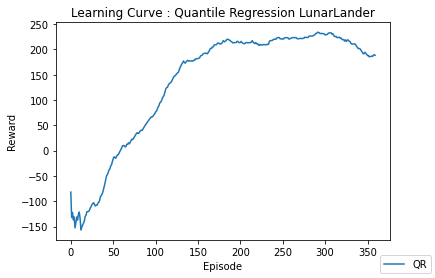

In [5]:
from tqdm import tqdm
QR=[]
def run(frames=1000, eps_fixed=False, eps_frames=1e6, min_eps=0.01):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    output_history = []
    frame = 0
    if eps_fixed:
        eps = 0
    else:
        eps = 1
    eps_start = 1
    i_episode = 1
    state = env.reset()
    score = 0                  
    for frame in tqdm(range(1, frames+1)):

        action = agent.act(state, eps)
        next_state, reward, done, _ = env.step(action)
        agent.step(state, action, reward, next_state, done, writer)
        state = next_state
        score += reward
        # linear annealing to the min epsilon value until eps_frames and from there slowly decease epsilon to 0 until the end of training
        if eps_fixed == False:
            if frame < eps_frames:
                eps = max(eps_start - (frame*(1/eps_frames)), min_eps)
            else:
                eps = max(min_eps - min_eps*((frame-eps_frames)/(frames-eps_frames)), 0.001)

        # evaluation runs
        if frame % 1000 == 0:
            eval_runs(eps, frame)
        
        if done:
            scores_window.append(score)       # save most recent score
            scores.append(score)              # save most recent score
            writer.add_scalar("Average100", np.mean(scores_window), frame)
            output_history.append(np.mean(scores_window))
            print('\rEpisode {}\tFrame {} \tAverage Score: {:.2f}'.format(i_episode, frame, np.mean(scores_window)), end="")
            if i_episode % 100 == 0:
                print('\rEpisode {}\tFrame {}\tAverage Score: {:.2f}'.format(i_episode,frame, np.mean(scores_window)))
            i_episode +=1 
            state = env.reset()
            score = 0  
            QR.append([i_episode,frame,np.mean(scores_window)])

    return output_history


if __name__ == "__main__":
    
    writer = SummaryWriter("runs/"+"DQN_LL_new_1")
    seed = 1
    BUFFER_SIZE = 100000
    BATCH_SIZE = 32
    GAMMA = 0.99
    TAU = 1e-2
    LR = 1e-3
    UPDATE_EVERY = 1
    n_step = 1
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Using ", device)




    np.random.seed(seed)
    env = gym.make("LunarLander-v2")

    env.seed(seed)
    action_size     = env.action_space.n
    state_size = env.observation_space.shape

    agent = DQN_Agent(state_size=state_size,    
                        action_size=action_size,
                        Network="DDQN",
                        layer_size=256,
                        n_step=n_step,
                        BATCH_SIZE=BATCH_SIZE, 
                        BUFFER_SIZE=BUFFER_SIZE, 
                        LR=LR, 
                        TAU=TAU, 
                        GAMMA=GAMMA, 
                        UPDATE_EVERY=UPDATE_EVERY, 
                        device=device, 
                        seed=seed)



    # set epsilon frames to 0 so no epsilon exploration
    eps_fixed = False

    t0 = time.time()
    final_average100 = run(frames = 120000, eps_fixed=eps_fixed, eps_frames=5000, min_eps=0.025)
    t1 = time.time()
    
    print("Training time: {}min".format(round((t1-t0)/60,2)))
    torch.save(agent.qnetwork_local.state_dict(), "DQN"+".pth")
    
    

df=pd.DataFrame(QR)
df.to_csv('QR_LunarLander_Result.csv')

fig=plt.figure()   
    
reward='QR_LunarLander'
df.to_csv(reward+'.csv')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot(df[2],  label='QR')


plt.title('Learning Curve : Quantile Regression LunarLander')

# agent.save('Model_dqn.h5')
fig.legend(loc='lower right')
fig.savefig(reward+'.png', dpi=100)
fig.show()   
        


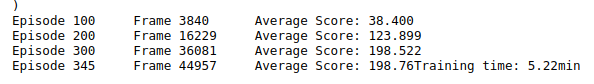